In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from util_visualization import plot_feature_importances, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import joblib
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Import Data

In [104]:
# Load the labeled index data from csv
labeled_index = pd.read_csv("../data/labeled_data/quarterly_labeled_index.csv")

In [105]:
labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())

## Z-Score Standardization

In [106]:
# Assuming your DataFrame is named df
features_columns = ['volatility', 'price_change', 'volume_change']

# Handle extreme value
labeled_index['volume_change'].replace([np.inf], 1e10, inplace=True)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected data
scaled_features = scaler.fit_transform(labeled_index[features_columns])

# Replace the original columns with the scaled values
labeled_index[features_columns] = scaled_features

In [107]:
# Save as csv
labeled_index.to_csv('../data/labeled_data/' + f"quarterly_labeled_index_standardized.csv", index=False)
print(f"Saved quarterly_labeled_index_standardized.csv")
print(labeled_index)

Saved quarterly_labeled_index_standardized.csv
            volatility      index  crash_label  price_change  volume_change  \
date                                                                          
31/3/1998    -0.628541  000001.SS            0      0.187709      -0.127147   
30/6/1998    -0.628541  000001.SS            0      0.504913      -0.127147   
30/9/1998    -0.625680  000001.SS            1     -0.795446      -0.127147   
31/12/1998   -0.631403  000001.SS            0     -0.843210      -0.127147   
31/3/1999    -0.629515  000001.SS            0     -0.082838      -0.127147   
...                ...        ...          ...           ...            ...   
31/12/2018   -0.493234      ^SSMI            0     -0.800378      -0.127147   
31/3/2019    -0.529809      ^SSMI            0      0.914383      -0.127147   
30/6/2019    -0.458321      ^SSMI            0      0.217264      -0.127147   
30/9/2019    -0.388212      ^SSMI            0     -0.010617      -0.127147   
31/12

## Build the model

In [108]:
# Call TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
evaluation = []
shap_values_list = []

for train_index, test_index in tscv.split(quarters):
    
    train_quarters, test_quarters = quarters[train_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE()
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Hyperparameter Tuning
    param_grid = {"penalty": ['none', 'l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs', 'liblinear', 'sag', 'saga']}
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=tscv, scoring='f1', verbose=2, error_score=0)
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Best Score: {best_score}")
    print("Grid search completed successfully.")

    # Train the model
    model = LogisticRegression(C=best_params['C'], solver=best_params['solver'])
    model.fit(X_train_resampled, y_train_resampled)
    
    # Save the trained model to a file
    #joblib.dump(model, 'logistic_regression_model.joblib')
    print("prediction model trained")
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Predict probabilities on the test data
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    conf_matrix = confusion_matrix(y_test, y_pred, labels= [0,1])
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X_test)
    shap_values_list.append(shap_values)
    
    evaluation_result = {
        'Train_Start': pd.to_datetime(train_quarters).min(),
        'Train_End': pd.to_datetime(train_quarters).max(),
        'Test_Start': pd.to_datetime(test_quarters).min(),
        'Test_End': pd.to_datetime(test_quarters).max(),
        'Confusion_Matrix': conf_matrix, #[[TN, FP],[FN,TP]]
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1, 
        'Accuracy': accuracy, 
        'RMSE': rmse,
        'MAPE': mape,
        'AUC-ROC': auc_roc,
        'False Positive Rate': fpr,
        'True Positive Rate': tpr
    }
    
    # Feature Importance
    feature_names = list(X_train.columns)
    feature_importance = model.coef_[0]
    for name, importance in zip(feature_names, feature_importance):
        evaluation_result[f"{name}_importance"] = importance

    # Append result to evaluation
    evaluation.append(evaluation_result)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..................C=0.001, penalty=none, solver=sag; total time=   0.0s
[CV] END ..................C=0.001, penalty=non

[CV] END ...................C=0.1, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=0.1, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=0.1, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=0.1, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0

[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................

[CV] END ....................C=1000, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=1000, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=1000, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=10

[CV] END .....................C=0.01, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................

[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...................

[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ......................C=100, penalty=l2, solver=sag; total time=   0.0s
[CV] END ...................

[CV] END ..................C=0.001, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.001, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.001, penalty=l2, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l2, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l2, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l2, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l2, solver=sag; total time=   0.0s
[CV] END ...................

[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ...................

[CV] END ....................C=100, penalty=none, solver=sag; total time=   0.0s
[CV] END ....................C=100, penalty=none, solver=sag; total time=   0.0s
[CV] END ....................C=100, penalty=none, solver=sag; total time=   0.0s
[CV] END ...................C=100, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=100, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=100, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=100, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=100, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..................C=0.001, penalty=none, solver=sag; total time=   0.0s
[CV] END ..................C=0.001, penalty=non

[CV] END ....................C=0.1, penalty=none, solver=sag; total time=   0.0s
[CV] END ....................C=0.1, penalty=none, solver=sag; total time=   0.0s
[CV] END ....................C=0.1, penalty=none, solver=sag; total time=   0.0s
[CV] END ....................C=0.1, penalty=none, solver=sag; total time=   0.0s
[CV] END ...................C=0.1, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=0.1, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=0.1, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=0.1, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=0.1, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................

[CV] END ....................C=10, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=10, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=10, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=10, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=10, penalty=none, solver=saga; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=

[CV] END ...................C=1000, penalty=none, solver=sag; total time=   0.0s
[CV] END ...................C=1000, penalty=none, solver=sag; total time=   0.0s
[CV] END ...................C=1000, penalty=none, solver=sag; total time=   0.0s
[CV] END ...................C=1000, penalty=none, solver=sag; total time=   0.0s
[CV] END ..................C=1000, penalty=none, solver=saga; total time=   0.0s
[CV] END ..................C=1000, penalty=none, solver=saga; total time=   0.0s
[CV] END ..................C=1000, penalty=none, solver=saga; total time=   0.0s
[CV] END ..................C=1000, penalty=none, solver=saga; total time=   0.0s
[CV] END ..................C=1000, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................C=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................C=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................

[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END ...................

[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...............C=10, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, penalty=none, solver=liblinear; total time=   0.0s
[CV] END .....................C=10, penalty=none, solver=sag; total time=   0.0s
[CV] END .....................C=10, penalty=none, solver=sag; total time=   0.0s
[CV] END ...................

[CV] END ...................C=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................C=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....................C=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END ...................

In [109]:
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('./evaluation_result/' + f"evaluation_benchmark.csv", index=False)
evaluation_df
#TODO: visualize it, seperate TN, TP, FP, FN

,Train_Start,Train_End,Test_Start,Test_End,Confusion_Matrix,Precision,Recall,F1,Accuracy,RMSE,MAPE,AUC-ROC,False Positive Rate,True Positive Rate,volatility_importance,price_change_importance,volume_change_importance
0,1998-06-30,2015-06-30,1998-09-30,2019-06-30,"[[85, 31], [0, 24]]",0.436364,1.000000,0.607595,0.778571,0.470562,inf,0.956537,"[0.0, 0.0, 0.0, 0.008620689655172414, 0.008620...","[0.0, 0.041666666666666664, 0.25, 0.25, 0.5416...",0.002343,-0.062377,-0.003945
1,1998-06-30,2019-06-30,1998-12-31,2019-09-30,"[[106, 13], [5, 16]]",0.551724,0.761905,0.640000,0.871429,0.358569,inf,0.833934,"[0.0, 0.0, 0.0, 0.008403361344537815, 0.008403...","[0.0, 0.047619047619047616, 0.1904761904761904...",-0.017294,-0.177180,-0.024551
2,1998-06-30,2019-09-30,2000-12-31,2013-12-31,"[[117, 10], [1, 12]]",0.545455,0.923077,0.685714,0.921429,0.280306,inf,0.967293,"[0.0, 0.0, 0.0, 0.007874015748031496, 0.007874...","[0.0, 0.07692307692307693, 0.6153846153846154,...",-0.032586,-0.226791,-0.018192
3,1998-06-30,2019-09-30,1998-03-31,2019-12-31,"[[109, 21], [4, 6]]",0.222222,0.600000,0.324324,0.821429,0.422577,inf,0.656923,"[0.0, 0.0, 0.0, 0.007692307692307693, 0.007692...","[0.0, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, ...",-0.004452,-0.309410,-0.011954
4,1998-03-31,2019-12-31,2006-03-31,2019-03-31,"[[103, 21], [3, 13]]",0.382353,0.812500,0.520000,0.828571,0.414039,inf,0.864415,"[0.0, 0.0, 0.0, 0.008064516129032258, 0.008064...","[0.0, 0.0625, 0.1875, 0.1875, 0.3125, 0.3125, ...",-0.007950,-0.312009,-0.025147


## Shap Values
- color: how higher and lower values of the feature will affect the result
- X-axis: impact on output

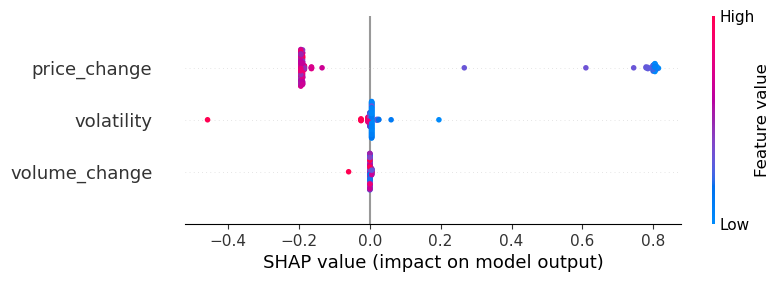

In [110]:
shap.plots.beeswarm(shap_values_list[4])

## Feature Importance

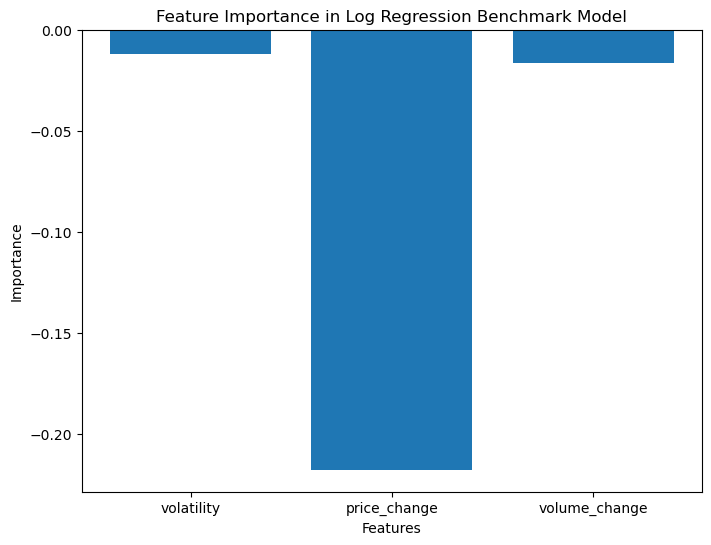

In [111]:
model_name = "Log Regression Benchmark"
plot_feature_importances(evaluation_df, model_name)

## AUC-ROC

In [112]:
print("Mean AUC Score: ", np.mean(evaluation_df['AUC-ROC']))

Mean AUC Score:  0.8558203758449296


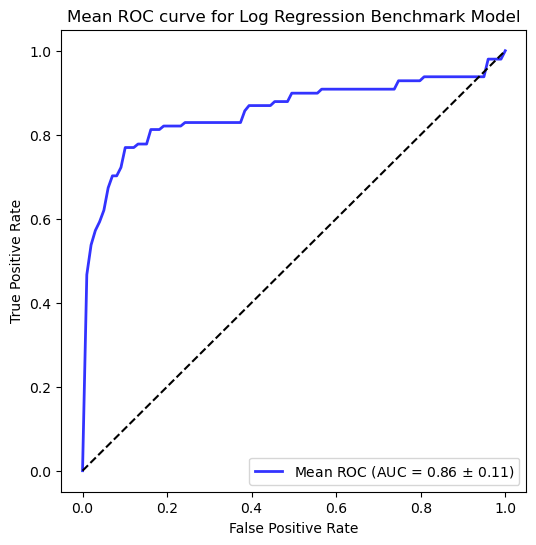

In [113]:
plot_roc_curve(evaluation_df, model_name)